In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()
    #save_filename = "figures/ctm_topic_space-tsne-train3000-no_bg.html"
    #fig.write_html(save_filename)


In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    # fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.show()

In [4]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
tasks = ['P', 'C', 'T']

df = pd.read_csv("concreteness_norms_last_hidden_state_embs.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="captioning", value="C", inplace=True)
df["task"].replace(to_replace="translation", value="T", inplace=True)
df.task.value_counts()

task
C    96720
P    96720
T    96720
Name: count, dtype: int64

In [7]:
# KMeans

def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.8300925925925926
std: 0.025977241198298077
Task: C
mean: 0.8281449553001277
std: 0.02948014977946599
Task: T
mean: 0.8480683269476372
std: 0.018720610517980726


<AxesSubplot:xlabel='task', ylabel='purity'>

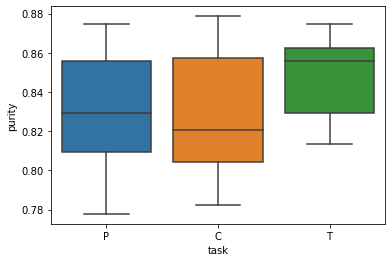

In [8]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [9]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
C_purity = task_purity[task_purity.task == 'C'].purity.to_list()
T_purity = task_purity[task_purity.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))

P vs C: KruskalResult(statistic=0.1372807685994792, pvalue=0.7109994019900486)
P vs T: KruskalResult(statistic=9.753452632196076, pvalue=0.0017898623520279046)
C vs T: KruskalResult(statistic=9.19008511536297, pvalue=0.0024332957481631094)


In [47]:
model_name = 'translation/downsample-n-none/5/translation_none_e10.pt'
concrete = df[(df.model == model_name) & (df.word_type == 'concrete')][:783]
abstract = df[(df.model == model_name) & (df.word_type == 'abstract')]
balance = pd.concat([concrete, abstract])
balance.word_type.value_counts()
df[df.model == model_name].word_type.value_counts()

word_type
concrete    1635
abstract     783
Name: count, dtype: int64

In [10]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.05406018950502237
std: 0.007379671723261823
Task: C
mean: 0.04981882097783306
std: 0.006457359783491406
Task: T
mean: 0.05690005209415304
std: 0.006605553476357976


In [11]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
C_sil = task_sil[task_sil.task == 'C'].sil.to_list()
T_sil = task_sil[task_sil.task == 'T'].sil.to_list()
print("P vs C:", kruskal(P_sil, C_sil))
print("P vs T:", kruskal(P_sil, T_sil))
print("C vs T:", kruskal(C_sil, T_sil))

P vs C: KruskalResult(statistic=6.259259259259267, pvalue=0.012354585017871901)
P vs T: KruskalResult(statistic=1.3556481481481342, pvalue=0.24429312172305379)
C vs T: KruskalResult(statistic=11.933425925925917, pvalue=0.0005513569270503431)


In [6]:
# Affinity propagation clustering
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    #print('emb_matrix:', emb_matrix.shape)
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8876596424010217
std: 0.005629279169142971
Task: C
mean: 0.8901979565772669
std: 0.0055272436952821125
Task: T


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8857439335887612
std: 0.005666304860634319


In [7]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
C_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'C'].purity.to_list()
T_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))


P vs C: KruskalResult(statistic=5.0370908450290885, pvalue=0.024810121135051055)
P vs T: KruskalResult(statistic=1.391604256418099, pvalue=0.23813436589068443)
C vs T: KruskalResult(statistic=11.006197908106998, pvalue=0.0009080772546040999)


In [8]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
mean: 0.9211047254150703
std: 0.012498266591078108
Task: C
mean: 0.9322158365261813
std: 0.01107409598039503
Task: T
mean: 0.9196200510855684
std: 0.011397594829936674


In [9]:
from scipy.stats import kruskal
task_purity_agg = pd.DataFrame.from_dict(task_purity_agg)
P_purity = task_purity_agg[task_purity_agg.task == 'P'].purity.to_list()
C_purity = task_purity_agg[task_purity_agg.task == 'C'].purity.to_list()
T_purity = task_purity_agg[task_purity_agg.task == 'T'].purity.to_list()
print("P vs C:", kruskal(P_purity, C_purity))
print("P vs T:", kruskal(P_purity, T_purity))
print("C vs T:", kruskal(C_purity, T_purity))

P vs C: KruskalResult(statistic=13.662460856408968, pvalue=0.0002187845853123075)
P vs T: KruskalResult(statistic=0.05117084413374062, pvalue=0.8210382995364761)
C vs T: KruskalResult(statistic=20.422415825211985, pvalue=6.209815861295692e-06)
